DATA CREATION

You're given synthetic user behavior data from a subscription-based learning app.  
You’ll classify users into personas based on engagement and value.

In [1]:
import pandas as pd
import numpy as np

np.random.seed(27)

n = 1000

df = pd.DataFrame({
    'User_ID': np.arange(1, n + 1),
    'Total_Sessions': np.random.poisson(25, n),
    'Avg_Session_Length_Min': np.round(np.random.normal(15, 5, n), 1),
    'Courses_Completed': np.random.poisson(3, n),
    'Subscription_Tier': np.random.choice(['Free', 'Basic', 'Premium'], p=[0.5, 0.3, 0.2], size=n),
    'Last_Login_Days_Ago': np.random.randint(1, 60, n),
    'Is_Referral_User': np.random.choice([0, 1], size=n, p=[0.7, 0.3])
})

df.to_csv("user_behavior_data.csv", index=False)


## Task:
1. User Segmentation:  
- Create 3 or 4 meaningful user segments (e.g., “Loyal Learners”, “Ghost Users”, “Referral Stars”) based on:
    - Engagement (sessions, courses)
    - Recency (last login)
    - Tier and referral status

- Use either:
    - Logic-based bucketing (if-else)
    - OR unsupervised clustering (KMeans)

2. Segment Summary Table:  
- For each segment, show:
    - Avg. sessions
    - Avg. course completion
    - Avg. session time
    - % of referral users 
    - Churn risk (proxy: Last_Login_Days_Ago > 30)

3. Targeting Strategy:  
- Recommend which segment(s) to target for:
    - Upsell to premium
    - Winback via reactivation email
    - Referral campaign push

In [2]:
df.head()

,User_ID,Total_Sessions,Avg_Session_Length_Min,Courses_Completed,Subscription_Tier,Last_Login_Days_Ago,Is_Referral_User
0,1,24,20.1,1,Premium,43,0
1,2,32,15.0,3,Premium,28,0
2,3,29,17.4,4,Free,13,0
3,4,20,24.3,5,Basic,48,0
4,5,23,6.7,2,Basic,24,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User_ID                 1000 non-null   int64  
 1   Total_Sessions          1000 non-null   int32  
 2   Avg_Session_Length_Min  1000 non-null   float64
 3   Courses_Completed       1000 non-null   int32  
 4   Subscription_Tier       1000 non-null   object 
 5   Last_Login_Days_Ago     1000 non-null   int32  
 6   Is_Referral_User        1000 non-null   int64  
dtypes: float64(1), int32(3), int64(2), object(1)
memory usage: 43.1+ KB


In [3]:
df.describe()

,User_ID,Total_Sessions,Avg_Session_Length_Min,Courses_Completed,Last_Login_Days_Ago,Is_Referral_User
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,24.999000,15.107400,2.943000,30.253000,0.267000
std,288.819436,5.098725,4.964257,1.730533,16.774754,0.442614
min,1.000000,9.000000,-2.700000,0.000000,1.000000,0.000000
25%,250.750000,21.000000,11.775000,2.000000,15.000000,0.000000
50%,500.500000,25.000000,15.100000,3.000000,31.000000,0.000000
75%,750.250000,28.000000,18.300000,4.000000,44.250000,1.000000
max,1000.000000,44.000000,28.500000,9.000000,59.000000,1.000000


In [8]:
df['Subscription_Tier'].value_counts()

Subscription_Tier
Free       495
Basic      295
Premium    210
Name: count, dtype: int64

In [22]:
# For categorical features
tier_map = {'Free':0,'Basic':1,'Premium':2}
df['Tier_encoded'] = df['Subscription_Tier'].map(tier_map)

# For numerical features
num_features = df[['Total_Sessions', 'Courses_Completed', 'Avg_Session_Length_Min',
               'Last_Login_Days_Ago', 'Is_Referral_User', 'Tier_encoded']]


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()
scaled_features = scaler.fit_transform(num_features)

In [24]:
sil_scores = []
k_range = range(2, 8)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(scaled_features)
    
    score = silhouette_score(scaled_features, labels)
    sil_scores.append(score)
    


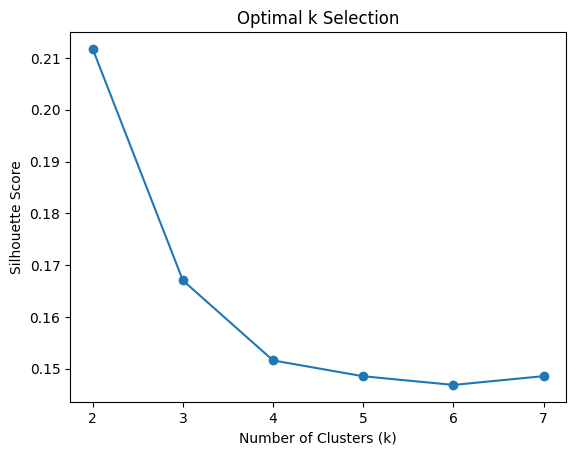

In [25]:
# Plot silhouette scores
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Optimal k Selection")
plt.show()

In [27]:
# Choose optimal k i.e 4
optimal_k = 4
Kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = Kmeans.fit_predict(scaled_features)

In [32]:
cluster_summary = df.groupby('cluster')[['Total_Sessions', 'Courses_Completed', 'Avg_Session_Length_Min',
                                         'Last_Login_Days_Ago', 'Is_Referral_User', 'Tier_encoded']].mean()
cluster_summary


,Total_Sessions,Courses_Completed,Avg_Session_Length_Min,Last_Login_Days_Ago,Is_Referral_User,Tier_encoded
cluster,,,,,,
0,26.474747,2.833333,14.667172,29.111111,0.0,1.767677
1,24.173913,3.239130,16.542029,44.166667,0.0,0.329710
2,25.003861,2.656371,14.066409,15.096525,0.0,0.281853
3,24.752809,2.996255,14.960674,31.419476,1.0,0.752809


In [34]:
# Based on summary stats 

cluster_map = {
    0: "Loyal Learner",
    1: "Ghost User",
    2: "Returning Freebies",
    3: "Referral Stars"
}
df['User_Segment'] = df['cluster'].map(cluster_map)


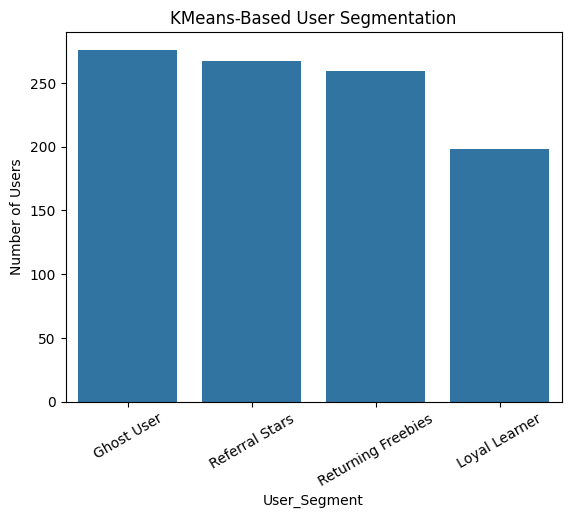

In [37]:
sns.countplot(data=df, x='User_Segment', order=df['User_Segment'].value_counts().index)
plt.title("KMeans-Based User Segmentation")
plt.xticks(rotation=30)
plt.ylabel("Number of Users")
plt.show()


In [38]:
df.head()

,User_ID,Total_Sessions,Avg_Session_Length_Min,Courses_Completed,Subscription_Tier,Last_Login_Days_Ago,Is_Referral_User,Tier_encoded,cluster,User_Segment
0,1,24,20.1,1,Premium,43,0,2,0,Loyal Learner
1,2,32,15.0,3,Premium,28,0,2,0,Loyal Learner
2,3,29,17.4,4,Free,13,0,0,2,Returning Freebies
3,4,20,24.3,5,Basic,48,0,1,1,Ghost User
4,5,23,6.7,2,Basic,24,0,1,2,Returning Freebies


In [45]:
df['Is_Referral_User'].mean() * 100

np.float64(26.700000000000003)

In [54]:
summary = pd.DataFrame({
    'Avg_session': [df['Total_Sessions'].mean()],
    'Avg_course_completion': [df['Courses_Completed'].mean()],
    'Avg_session_time': [df['Avg_Session_Length_Min'].mean()],
    'Referral_use_%': [df['Is_Referral_User'].mean() * 100],
    'Churn_risk': [np.mean(df['Last_Login_Days_Ago'] > 30) * 100]  
})

In [59]:
summary.round(2)

,Avg_session,Avg_course_completion,Avg_session_time,Referral_use_%,Churn_risk
0,25.0,2.94,15.11,26.7,50.5
